In [2]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
## Loading images with integer value intensities, range(0-255)
def load_rgb(path):
    img = cv.imread(path)
    img = img[..., ::-1]
    return img

def load_gray(path):
    img = cv.imread(path, 0)
    return img

def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../data/outs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../data/outs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

### Eye Highlights

Text(0.5, 1.0, 'Input 1')

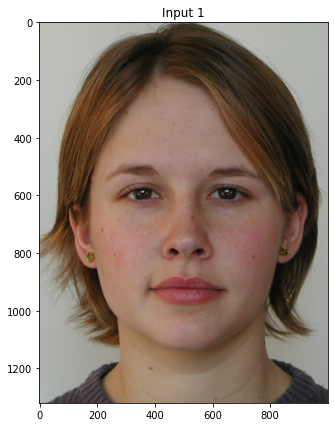

In [4]:
input_1 = cv.imread("../data/inputs/input_1.png")
input_1_rgb = cv.cvtColor(input_1, cv.COLOR_BGR2RGB)
input_1_gray = cv.cvtColor(input_1, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(7, 7))
plt.imshow(input_1_rgb, cmap='gray')
plt.title("Input 1")

Text(0.5, 1.0, 'Example 1')

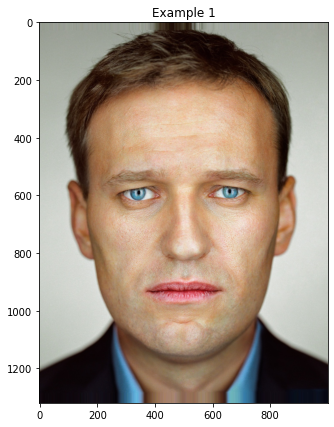

In [5]:
example_1 = cv.imread("../data/inputs/example_1.png")
example_1_rgb = cv.cvtColor(example_1, cv.COLOR_BGR2RGB)
example_1_gray = cv.cvtColor(example_1, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(7, 7))
plt.imshow(example_1_rgb, cmap='gray')
plt.title("Example 1")

#### Specular Reflection

In [36]:
# given a headshot image, return a mask of the eyeball of the face
def get_eyeball_mask(img):
        
        # get face mask
        face_mask = get_face_mask(img)
        
        # get eyeball mask
        eyeball_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')
        eyeballs = eyeball_cascade.detectMultiScale(img, 1.1, 4)
        
        # create mask
        mask = np.zeros_like(img)
        for (x, y, w, h) in eyeballs:
            # cv.ellipse(iris, (x + w//2, y + h//2), (w//2, h//2), 0, 0, 360, 255, -1)
            # cv.ellipse(mask, (x, y), (x+w, y+h), 255, -1)
            cv.ellipse(mask, (x + w//2, y + h//2), (w//2, h//2), 0, 0, 360, 255, -1)
        
        # combine masks
        mask = cv.bitwise_and(mask, face_mask)
        
        return mask
        
def get_face_mask(img):

    # detect faces
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, 1.1, 4)
    
    # create mask
    mask = np.zeros_like(img)
    for (x, y, w, h) in faces:
        # cv.ellipse(mask, (x, y), (x+w, y+h), 255, -1)
        cv.ellipse(mask, (x + w//2, y + h//2), (w//2, h//2), 0, 0, 360, 255, -1)
    
    return mask

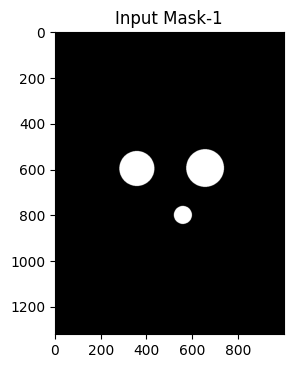

In [37]:
input_mask = get_eyeball_mask(input_1_gray)
plot_grayscale(input_mask, title = "Input Mask-1")

In [38]:
# separate specular reflection from the image eyeball region
def separate_specular(img, mask):
        
        # get the eyeball region
        eyeball_region = cv.bitwise_and(img, img, mask=mask)
        
        # get the specular reflection
        specular_region = cv.bitwise_and(img, img, mask=cv.bitwise_not(mask))
        
        return eyeball_region, specular_region



In [39]:
# copy the specular reflection from the image eyeball region onto another image's eyeball region
def copy_specular(img, mask, specular):
    
    # get the eyeball region
    eyeball = cv.bitwise_and(img, img, mask=mask)
    
    # copy the specular reflection onto the eyeball region
    eyeball = cv.bitwise_or(eyeball, specular)
    
    return eyeball

Text(0.5, 1.0, 'Example 1 Specular')

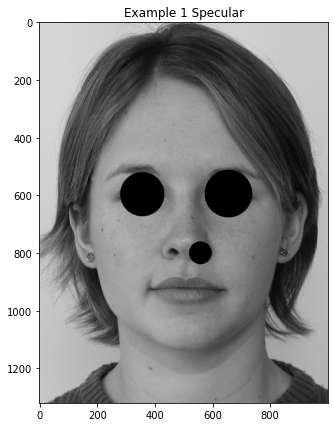

In [40]:
example_specular = separate_specular(input_1_gray, input_mask)[1]
plt.figure(figsize=(7, 7))
plt.imshow(example_specular, cmap='gray')
plt.title("Example 1 Specular")

Text(0.5, 1.0, 'Input Specular')

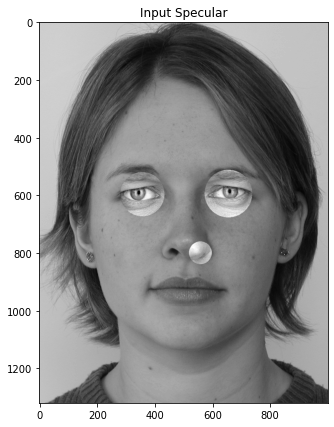

In [41]:
input_specular = copy_specular(example_1_gray, input_mask, example_specular)
plt.figure(figsize=(7, 7))
plt.imshow(input_specular, cmap='gray')
plt.title("Input Specular")

In [92]:
# locate the iris region using circular arc detection around the position of the pupil
def get_iris_mask(img, mask):
        
        # get the eyeball region
        eyeball = cv.bitwise_and(img, img, mask=mask)
        
        # get the pupil region
        pupil_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')
        pupils = pupil_cascade.detectMultiScale(eyeball, 1.1, 4)
        # print("Pupils", pupils.shape)
        # plt.imshow(pupils, cmap = "gray")

        # get the iris region
        iris = np.zeros_like(eyeball)
        for (x, y, w, h) in pupils:
            iris = cv.ellipse(iris, (x + w//2, y + h//2), (w//2, h//2), 0, 0, 360, 255, -1)
        
        # combine masks
        iris = cv.bitwise_and(eyeball, iris, mask=mask)

        
        # # create mask
        # mask = np.zeros_like(img)
        # for (x, y, w, h) in pupils:
        #     cv.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
        
        # # get the iris region
        # iris = cv.bitwise_and(eyeball, eyeball, mask=mask)
        
        return iris

Text(0.5, 1.0, 'Example 1 Iris')

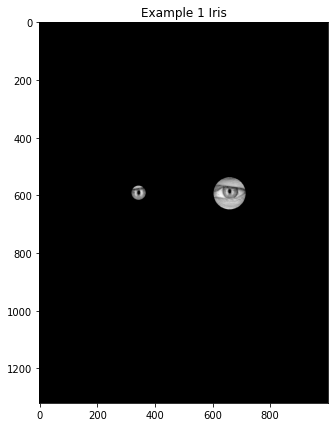

In [93]:
example_iris = get_iris_mask(example_1_gray, input_mask)
plt.figure(figsize=(7, 7))
plt.imshow(example_iris, cmap='gray')
plt.title("Example 1 Iris")


In [81]:
# copy the iris mask on another image onto the eyeball region
def copy_iris(img, mask, iris):
        
        # get the eyeball region
        eyeball = cv.bitwise_and(img, iris, mask=mask)
        
        # copy the iris onto the eyeball region
        eyeball = cv.bitwise_or(eyeball, iris)
        
        return eyeball

Text(0.5, 1.0, 'Masked Iris')

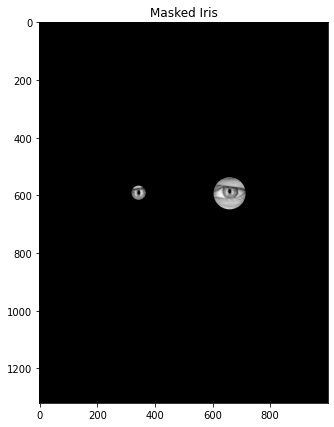

In [82]:
input_specular = copy_iris(input_1_gray, input_mask, example_iris)
plt.figure(figsize=(7, 7))
plt.imshow(input_specular, cmap='gray')
plt.title("Masked Iris")

In [83]:
# merge iris masked image onto the input image
def merge_iris(img, mask, iris):
        
    # get the eyeball region
    eyeball = cv.bitwise_and(img, iris, mask=mask)
        
    # copy the iris onto the eyeball region
    eyeball = cv.bitwise_or(eyeball, iris)
        
    # merge the iris onto the input image
    img = cv.bitwise_or(img, eyeball)
        
    return img

Text(0.5, 1.0, 'Merged Iris')

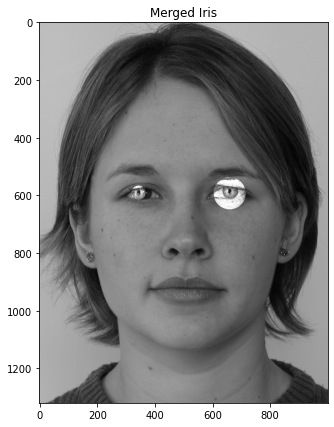

In [84]:
merge_input = merge_iris(input_1_gray, input_mask, example_iris)
plt.figure(figsize=(7, 7))
plt.imshow(merge_input, cmap='gray')
plt.title("Merged Iris")


In [85]:
# create approximate segmentation in to iris and pupil by running a k-means clustering algorithm on the pixel colors with k = 3
def get_iris_pupil_mask(img, mask):
            
    # get the eyeball region
    eyeball = cv.bitwise_and(img, img, mask=mask)
            
    # get the iris region
    iris = get_iris_mask(img, mask)
            
    # get the iris region mask
    iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
            
    # get the pupil region
    pupil = cv.bitwise_and(eyeball, eyeball, mask=cv.bitwise_not(iris_mask))
            
    # get the pupil region mask
    pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
            
    return iris_mask, pupil_mask

In [49]:
def replace_bkg(matched, style, input, style_mask, input_mask, vx, vy):
        temp = np.zeros(input.shape, dtype=np.uint8)
        temp[style_mask == 0] = style[style_mask == 0]
        temp[input_mask == 255] = 0
        # xy = (255 - style_mask).astype(np.uint8)
        # bkg = cv.inpaint(temp, xy[:, :, 0], 10, cv.INPAINT_TELEA)
        # imsave('output/bkg.jpg', bkg.astype(int))
        # TODO: Extrapolate background
        xy = np.logical_not(input_mask.astype(bool))
        matched[xy] = 0
        output = temp + matched
        output[output > 255] = 255
        output[output <= 0] = 0
        output = output.astype(int)
        # imsave('output/temp.jpg', output)
        # # imsave('output/temp.jpg', style.astype(int))
        return matched

In [86]:
def eye_highlight(matched, style, input, style_mask, input_mask, vx, vy):
    return matched

Text(0.5, 1.0, 'Input 1')

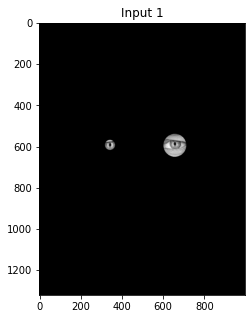

In [87]:
input_eye = eye_highlight(input_specular, example_1_gray, input_1_gray, input_mask, input_mask, 0, 0)
plt.figure(figsize=(5, 5))
plt.imshow(input_eye, cmap='gray')
plt.title("Input 1")


In [94]:
# k-means algorithm 
def kmeans(img, mask, k):
        
        # get the eyeball region
        eyeball = cv.bitwise_and(img, img, mask=mask)
        
        # reshape the image into a 2D array of pixels and 3 color values (RGB)
        pixel_values = eyeball.reshape((-1, 3))
        
        # convert to float
        pixel_values = np.float32(pixel_values)
        
        # define stopping criteria
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        
        # number of clusters (K)
        k = k
        
        # perform k-means clustering
        _, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
        
        # convert back to 8 bit values
        centers = np.uint8(centers)
        
        # flatten the labels array
        labels = labels.flatten()
        
        # convert all pixels to the color of the centroids
        segmented_image = centers[labels.flatten()]
        
        # reshape back to the original image dimension
        segmented_image = segmented_image.reshape(eyeball.shape)
        
        return segmented_image

Text(0.5, 1.0, 'Input 1 K-Means')

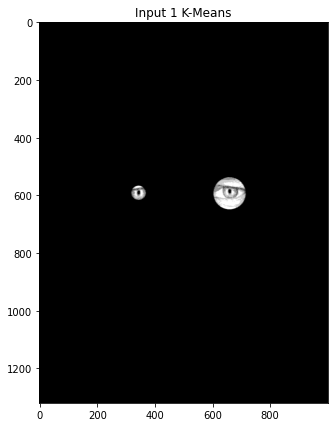

In [95]:
input_kmeans = kmeans(example_1_gray, example_iris, k=5)
plt.figure(figsize=(7, 7))
plt.imshow(input_kmeans, cmap='gray')
plt.title("Input 1 K-Means")


In [99]:
# refine reflection mask using alpha matting
def refine_mask(img, mask):
            
            # get the eyeball region
            eyeball = cv.bitwise_and(img, img, mask=mask)
            
            # get the iris region
            iris = get_iris_mask(img, mask)
            
            # get the iris region mask
            iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
            
            # get the pupil region
            pupil = cv.bitwise_and(eyeball, eyeball, mask=cv.bitwise_not(iris_mask))
            
            # get the pupil region mask
            pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
            
            # get the iris region
            iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
            
            # get the iris region mask
            iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
            
            # get the pupil region
            pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
            
            # get the pupil region mask
            pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
            
            # get the iris region
            iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
            
            # get the iris region mask
            iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
            
            # get the pupil region
            pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
            
            # get the pupil region mask
            pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
            
            # get the iris region
            iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
            
            # get the iris region mask
            iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
            
            # get the pupil region
            pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
            
            # get the pupil region mask
            pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
            
            # get the iris region
            iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
            
            # get the iris region mask
            iris_mask = cv.bitwise_not(cv.bitwise_and(iris, iris))

TypeError: Image data of dtype object cannot be converted to float

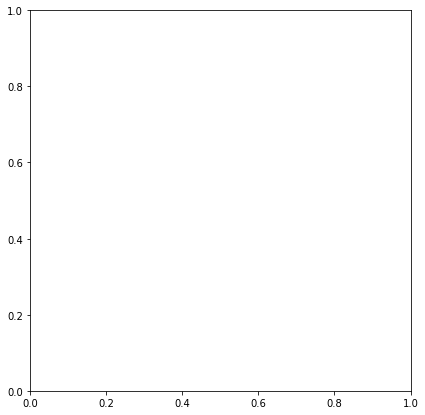

In [100]:
refine_iris = refine_mask(example_1_gray, example_iris)
plt.figure(figsize=(7, 7))
plt.imshow(refine_iris, cmap='gray')
plt.title("Input 1 Refine Iris")
 

In [101]:
# detect existing highlights as brightest pixels in the iris region
def detect_highlight(img, mask):
        
        # get the eyeball region
        eyeball = cv.bitwise_and(img, img, mask=mask)
        
        # get the iris region
        iris = get_iris_mask(img, mask)
        
        # get the iris region mask
        iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
        
        # get the pupil region
        pupil = cv.bitwise_and(eyeball, eyeball, mask=cv.bitwise_not(iris_mask))
        
        # get the pupil region mask
        pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
        
        # get the iris region
        iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
        
        # get the iris region mask
        iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
        
        # get the pupil region
        pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
        
        # get the pupil region mask
        pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
        
        # get the iris region
        iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
        
        # get the iris region mask
        iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
        
        # get the pupil region
        pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
        
        # get the pupil region mask
        pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
        
        # get the iris region
        iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
        
        # get the iris region mask
        iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))
        
        # get the pupil region
        pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
        
        # get the pupil region mask
        pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
        
        # get the iris region
        iris = cv.bitwise_and(eyeball, eyeball, mask=iris_mask)
        
        # get the iris region mask
        iris_mask = cv.bitwise_not(cv.bitwise_xor(iris, iris))

        return iris_mask

Text(0.5, 1.0, 'Input 1 Iris Refine')

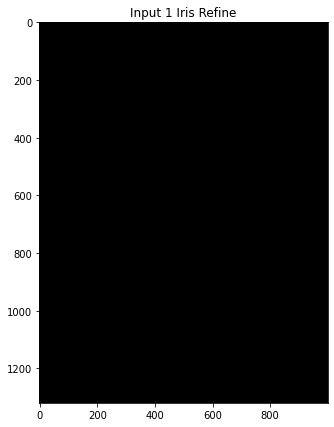

In [102]:
iris_refine = detect_highlight(example_1_gray, example_iris)
plt.figure(figsize=(7, 7))
plt.imshow(iris_refine, cmap='gray')
plt.title("Input 1 Iris Refine")


In [96]:
# refine reflection mask by removing the pupil region
# def refine_mask(img, mask):
            
#             # get the eyeball region
#             eyeball = cv.bitwise_and(img, img, mask=mask)
            
#             # get the iris and pupil region masks
#             iris_mask, pupil_mask = get_iris_pupil_mask(img, mask)
            
#             # get the pupil region
#             pupil = cv.bitwise_and(eyeball, eyeball, mask=pupil_mask)
            
#             # get the pupil region mask
#             pupil_mask = cv.bitwise_not(cv.bitwise_xor(pupil, pupil))
            
#             # refine the mask by removing the pupil region
#             mask = cv.bitwise_and(mask, mask, mask=cv.bitwise_not(pupil_mask))
            
#             return mask

Text(0.5, 1.0, 'Pupil Refinement')

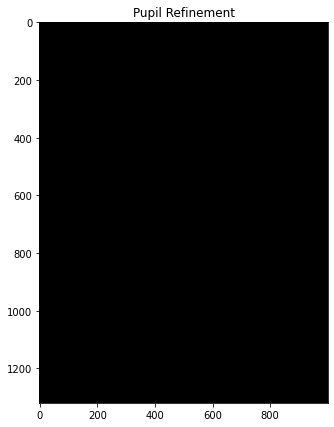

In [97]:
pupil_refine = refine_mask(example_1_gray, example_iris)
plt.figure(figsize=(7, 7))
plt.imshow(pupil_refine, cmap='gray')
plt.title("Pupil Refinement")


#### Background masking

Height of fg: 1320 Width of fg: 1000
Height of bg: 1320 Width of bg: 1000


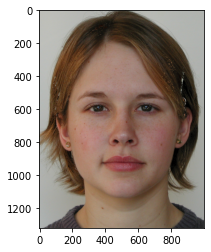

In [ ]:
def masking(fg):
  r, g, b = fg[:, :, 0], fg[:, :, 1], fg[:, :, 2]
  # plt.imshow(fg)
  ## MASKING
  # now, we need to make a color threshold to remove the green region
  # for that, we'll need to define a lower and upper bounds for the color that we need to isolate and remove, which here is green
  lower_green = np.array([0, 100, 0]) # [R, G, B]
  upper_green = np.array([10, 255, 10])
  # Figure out which ones we need to zero & zero them
  should_zero = (g > r+60) | (g > b+60)
  g[should_zero] = 0
  r[should_zero] = 0
  b[should_zero] = 0

  # print(should_zero)
  # plt.axis('off')
  plt.imshow(fg)
  # mask = cv2.inRange(fg, lower_green, upper_green)
  # plt.imshow(mask, cmap = 'gray')
 
mask_fg = masking(example_1_rgb)

print("Height of fg:", example_1_rgb.shape[0], "Width of fg:", example_1_rgb.shape[1])
print("Height of bg:", input_1_rgb.shape[0], "Width of bg:", input_1_rgb.shape[1])

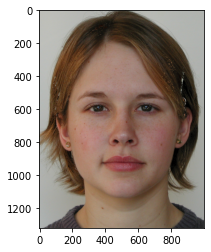

In [ ]:
def mergeImage(fg, bg, coord = (0, 0)):
  h_fg, w_fg, c_fg = fg.shape
  h_bg, w_bg, c_bg = bg.shape

  # making starting coordinates of the image (if not starting from (0, 0))
  coord = (0, 0)
  (y_0, x_0) = coord
  x_n = x_0 + h_fg
  y_n = y_0 + w_fg

  bg_crop = bg[x_0:x_n, y_0:y_n, :]

  pixel_preserve = (fg[:, :, -1] > 10)
  bg_crop[pixel_preserve] = fg[pixel_preserve]

  bg[x_0:x_n, y_0:y_n, :] = bg_crop

  # plt.axis('off')
  plt.imshow(bg)

# will be using the fg_rgb image that we got through masking
mergeImage(input_1_rgb, example_1_rgb, coord = (0, 0))